## Snippet: Limits Profiles, Mixed Severity, and Frequency Mixing

The `Aggregate` distribution class manages creation and calculation of aggregate distributions.
It allows for very flexible creation of aggregate distributions, including  a limit profile, 
a mixed severity, or both. Mixed frequency types share
a mixing distribution across all broadcast terms to ensure an appropriate inter-
class correlation.

### Limit profiles
The exposure variables can be vectors to express a *limit profile*.
All ```exp_[en|prem|loss|count]``` related elements are broadcast against one-another.
For example

    agg Eg1 [1000 2000 4000 1000] premium at 0.65 lr [1000 2000 5000 4000] xs [0 0 0 1000] sev lognorm 500 cv 1.25 mixed gamma 0.6

expresses a limit profile with 1000 of premium at 1000 x 0; 2000 at 2000 x 0
4000 at 5000 x 0 and 1000 at 4000 x 1000. In this case all the loss ratios are
the same, but they could vary too.

Note that an aggregate with a mixed severity is a sum of aggregates, with the mixture weights applied
to the expected claim count. This is analogous to the fact that $\exp(a+b)=\exp(a)\exp(b)$. In terms of 
compound Poisson, $$\mathsf{CP}(\lambda, \sum w_iF_i)=_d \sum_i \mathsf{CP}(w_i \lambda, F_i)$$
where $=_d$ indcates the two sides have the same distribution. 

In this case we have selected a mixed frequency, using a gamma CV 0.6 mixing distribution. All of the limits 
share the same mixing variable. The effect of this is shown in the report_df, comparing the independent 
and mixed columns. The former adds the mixture components independently whereas the latter
uses the common mixing variable. The increase in aggregate CV is quite marked. 

In [8]:
import aggregate as agg
# uw appropriate for snippet 
build = agg.Underwriter(name='Mixtures', update=True, log2=16)
build.logger_level(30)

time: 0 ns (started: 2022-10-25 21:40:10 +01:00)


view,0,1,2,3,independent,mixed,empirical,error
statistic,,,,,,,,
name,Eg1,Eg1,Eg1,Eg1,Eg1,Eg1,,
limit,1.000k,2.000k,5.000k,4.000k,3.518k,3.518k,,
attachment,0.000,0.000,0.000,1.000k,83.724,83.724,,
el,650.000,1.300k,2.600k,650.000,5.200k,5.200k,,
freq_m,1.583,2.770,5.243,876.845m,10.473,10.473,,
freq_cv,995.790m,849.127m,742.112m,1.225,470.785m,674.895m,,
freq_skew,1.357,1.273,1.227,1.519,801.360m,1.208,,
sev_m,410.538,469.322,495.900,741.294,496.511,496.511,496.511,-221.166n
sev_cv,745.342m,963.843m,1.164,1.144,1.106,1.106,1.106,3.951u


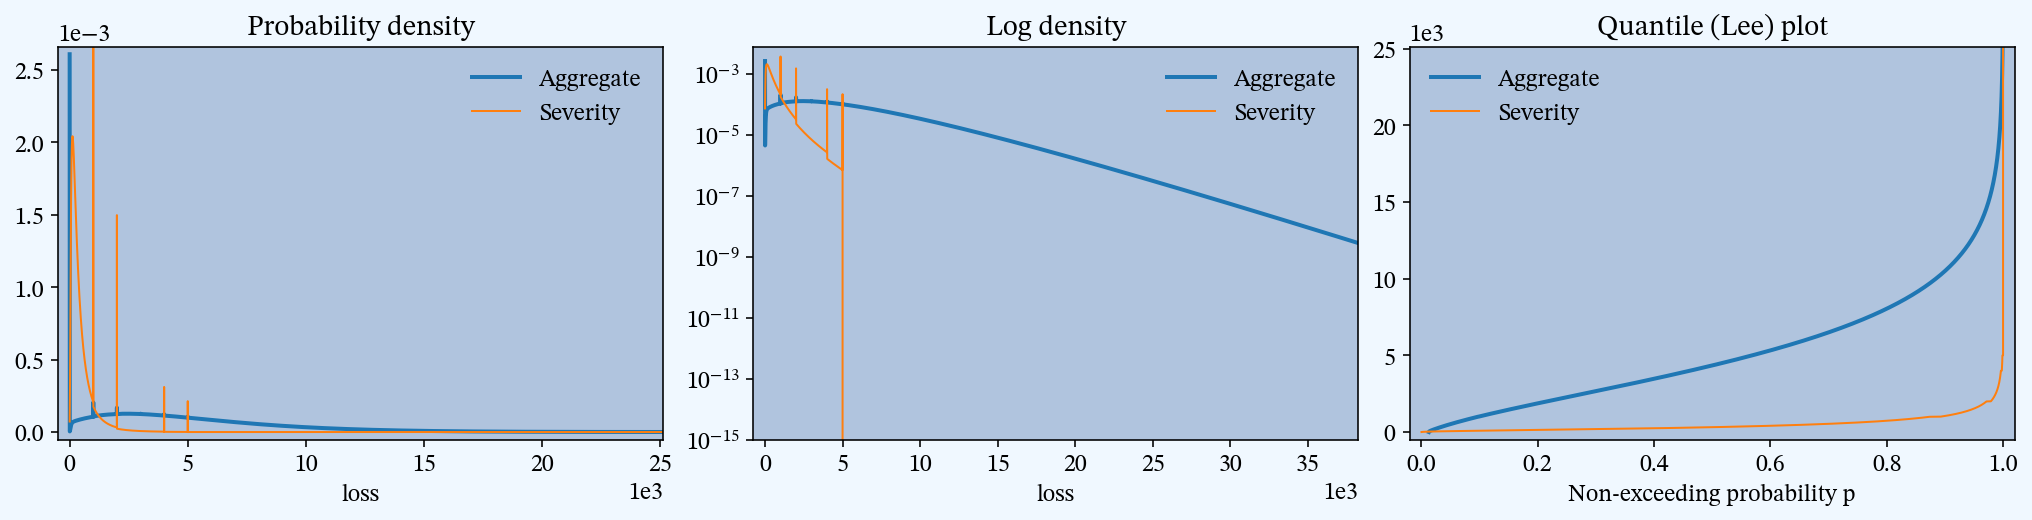

time: 1.05 s (started: 2022-10-25 21:40:13 +01:00)


In [9]:
# limit profile
eg1 = build('agg Eg1 [1000 2000 4000 1000] premium at 0.65 lr '
            '[1000 2000 5000 4000] xs [0 0 0 1000] '
            'sev lognorm 500 cv 1.25 '
            'mixed gamma 0.6')
eg1.plot()
eg1.report_df

### Mixed severity distributions
The severity variables can be vectors to express a *mixed severity*. All severity
elements are broadcast against one-another. For example

    sev lognorm 1000 cv [0.75 1.0 1.25 1.5 2] wts [0.4, 0.2, 0.1, 0.1, 0.1]

expresses a mixture of five lognormals with a mean of 1000 and CVs as indicated with
weights 0.4, 0.2, 0.1, 0.1, 0.1. Equal weights can be expressed using the shorthand `wts=5`. 
A missing weights clause is interpreted as giving each severity weight 1 which results in five
times the total loss. 

In [10]:
# mixed severity
eg2 = build('agg Eg2 1000 loss sev lognorm 100 cv [0.75 1.0 1.25 1.5 2] wts [0.4, 0.2, 0.1, 0.1, 0.1] poisson')
eg2.report_df

view,0,1,2,3,4,independent,mixed,empirical,error
statistic,,,,,,,,,
name,Eg2,Eg2,Eg2,Eg2,Eg2,Eg2,Eg2,,
limit,inf,inf,inf,inf,inf,inf,inf,,
attachment,0,0,0,0,0,0.000,0.000,,
el,400.000,200.000,100.000,100.000,100.000,900.000,900.000,,
freq_m,4.000,2.000,1000.000m,1000.000m,1000.000m,9.000,9.000,,
freq_cv,500.000m,707.107m,1.000,1.000,1.000,333.333m,333.333m,,
freq_skew,500.000m,707.107m,1.000,1.000,1.000,333.333m,333.333m,,
sev_m,100.000,100.000,100.000,100.000,100.000,100.000,100.000,99.853,-1.467m
sev_cv,750.000m,1.000,1.250,1.500,2.000,1.158,1.158,1.116,-35.853m


time: 1.02 s (started: 2022-10-25 21:40:19 +01:00)


In [11]:
# mixed severity with poisson frequency is the same as the sum of five independent components
egPort = build('''
port EgPort
    agg Unit1 400 loss sev lognorm 100 cv 0.75 poisson
    agg Unit2 200 loss sev lognorm 100 cv 1.00 poisson
    agg Unit3 100 loss sev lognorm 100 cv 1.25 poisson
    agg Unit4 100 loss sev lognorm 100 cv 1.50 poisson
    agg Unit5 100 loss sev lognorm 100 cv 2.00 poisson

''')
egPort.report_df

unit,Unit1,Unit2,Unit3,Unit4,Unit5,total
statistic,,,,,,
freq_m,4.000,2.000,1000.000m,1000.000m,1000.000m,9.000
freq_cv,500.000m,707.107m,1.000,1.000,1.000,333.333m
freq_skew,500.000m,707.107m,1.000,1.000,1.000,333.333m
sev_m,100.000,100.000,100.000,100.000,100.000,100.000
sev_cv,750.000m,1.000,1.250,1.500,2.000,1.158
sev_skew,2.672,4.000,5.703,7.875,14.000,11.617
agg_m,400.000,200.000,100.000,100.000,100.000,900.000
agg_emp_m,400.000,200.000,100.000,99.998,99.964,899.956
agg_m_err,-160.205f,-7.807n,-959.501n,-16.483u,-359.534u,-49.314u


time: 1.55 s (started: 2022-10-25 21:40:22 +01:00)


In [ ]:
# actual frequency = total frequency x weight; wts=5 sets equal weights, here 0.2
# 
eg2e = build('agg Eg2e 1000 loss sev lognorm 100 cv [0.75 1.0 1.25 1.5 2] wts=5 poisson')
eg2e.report_df

In [ ]:
# missing weights set to 1 resulting in five times loss
eg2m = build('agg Eg2m 1000 loss sev lognorm 100 cv [0.75 1.0 1.25 1.5 2] poisson')
eg2m.report_df

### Limit profiles and mixed severity
Limit profiles and mixtures can be combined. Each mixed severity is applied to each
limit profile component. For example

    agg Eg3 [10 20 30] claims [100 200 75] xs [0 50 75] sev lognorm 100 cv [1 2] wts [.6 .4] mixed gamma 0.4

creates an aggregate with six severity subcomponents:

|  #  |   limit |   attachment |   claims |
|:---:|--------:|-------------:|---------:|
|  0  |     100 |            0 |        6 |
|  1  |     100 |            0 |        4 |
|  2  |     200 |           50 |       12 |
|  3  |     200 |           50 |        8 |
|  4  |      75 |           75 |       18 |
|  5  |      75 |           75 |       12 |

view,0,1,2,3,4,5,independent,mixed,empirical,error
statistic,,,,,,,,,,
name,Eg3,Eg3,Eg3,Eg3,Eg3,Eg3,Eg3,Eg3,,
limit,100.000,100.000,200.000,200.000,75.000,75.000,120.833,120.833,,
attachment,0.000,0.000,50.000,50.000,75.000,75.000,54.167,54.167,,
el,406.324,210.349,867.573,692.258,862.366,634.176,3.673k,3.673k,,
freq_m,6.000,4.000,12.000,8.000,18.000,12.000,60.000,60.000,,
freq_cv,408.248m,500.000m,288.675m,353.553m,235.702m,288.675m,129.099m,129.099m,,
freq_skew,408.248m,500.000m,288.675m,353.553m,235.702m,288.675m,129.099m,129.099m,,
sev_m,67.721,52.587,72.298,86.532,47.909,52.848,61.217,61.217,61.217,-5.217u
sev_cv,447.211m,683.016m,866.527m,827.510m,566.427m,504.826m,765.485m,765.485m,765.510m,32.605u


,E(X),Est E(X),Err E(X),CV(X),Est CV(X),Err CV(X),Skew(X)
X,,,,,,,
Sev,61.217,61.217,-5.217u,765.485m,765.510m,32.605u,1.260
Freq,60.000,,,129.099m,,,129.099m
Agg,3.673k,3.673k,-5.218u,162.582m,162.584m,12.045u,214.784m


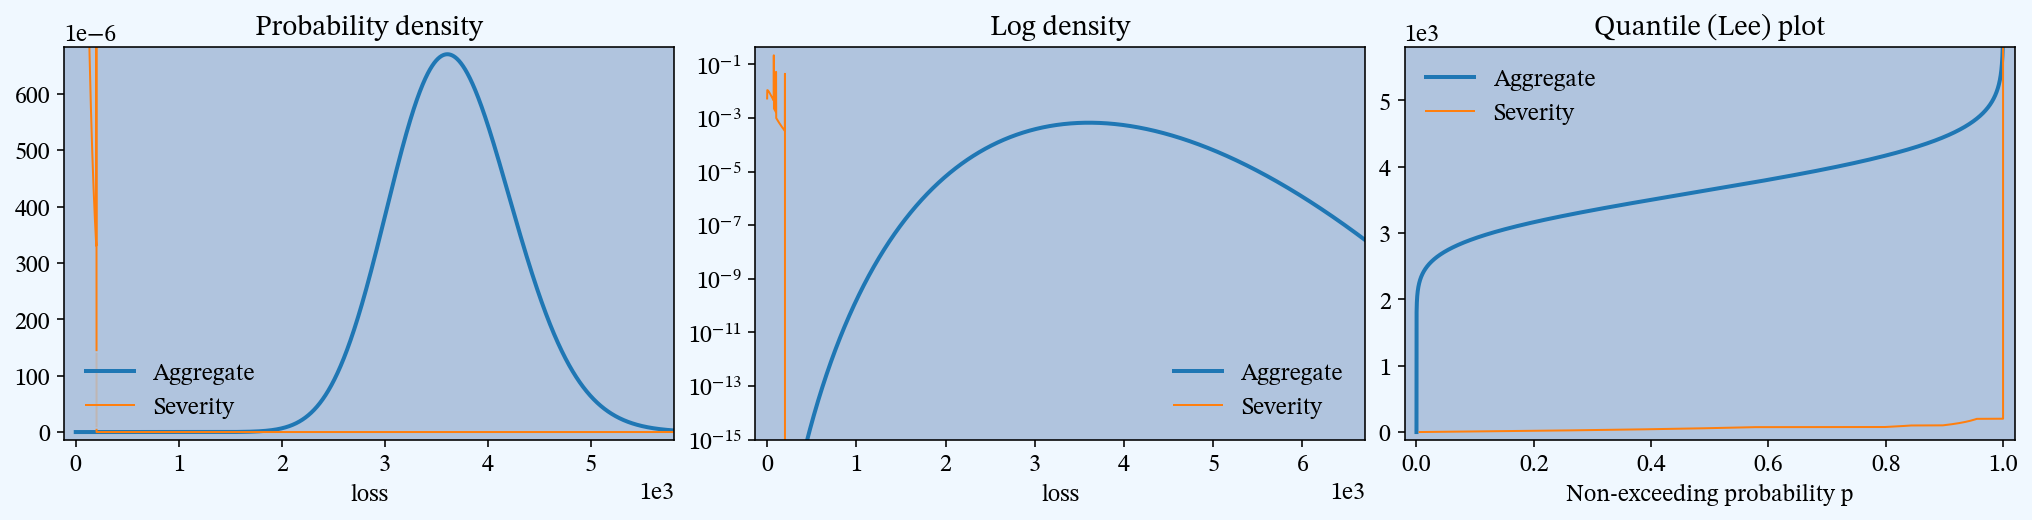

time: 1.08 s (started: 2022-10-25 21:45:29 +01:00)


In [12]:
# limits profile and mixed severity
eg3 = build('agg Eg3 [10 20 30] claims [100 200 75] xs [0 50 75] '
            'sev lognorm 100 cv [1 2] wts [0.6 0.4] '
            'poisson')
display(eg3)
display(eg3.report_df)
eg3.plot()

### Limit profiles with different severities: circumventing products
Exposures with different limits may have different severity curves. In this case, the limit profile 
and severity curves should all be broadcast together, rather than broadcasting limits and severities 
separately and then taking the outer product as in the previous example. To achieve this omit the weight clause:

    agg Eg4 [10 10 10] claims [1000 2000 5000] xs 0 \
        sev lognorm [50 100 150] cv [0.1 0.15 0.2] \
        poisson

The interpretation is determined by the total weights. If the weights sum to
one then the severity is interpreted as a mixture, and the result is an exposure / severity product as above. 
If the weights do not sum to one, they are used to adjust the exposure. 
If the weights clause is missing, then the weights are all set equal to 1 and the result is a different severity for 
each limit band with the requested exposure. 
(If the weights are specified and sum to the number of severity components then they are used to adjust the 
expected losses. Usually, this is not the desired behavior.) **TODO: what is wts sum to neither?**

In [13]:
# limits profile where each limit band has a different severity curve
eg4 = build('agg Eg4 [10 10 10] claims [1000 2000 5000] xs 0 '
            'sev lognorm [50 100 150] cv [0.1 0.15 0.2] '
            'poisson')
eg4.report_df

view,0,1,2,independent,mixed,empirical,error
statistic,,,,,,,
name,Eg4,Eg4,Eg4,Eg4,Eg4,,
limit,1.000k,2.000k,5.000k,2.667k,2.667k,,
attachment,0.000,0.000,0.000,0.000,0.000,,
el,500.000,1.000k,1.500k,3.000k,3.000k,,
freq_m,10.000,10.000,10.000,30.000,30.000,,
freq_cv,316.228m,316.228m,316.228m,182.574m,182.574m,,
freq_skew,316.228m,316.228m,316.228m,182.574m,182.574m,,
sev_m,50.000,100.000,150.000,100.000,100.000,100.000,-83.049p
sev_cv,100.000m,150.000m,200.000m,452.769m,452.769m,452.778m,20.323u


time: 454 ms (started: 2022-10-25 21:47:46 +01:00)


In [20]:
# adding weights that sum to the number of components adjusts expected losses
eg4m = build('agg Eg4m [10 10 10] claims [1000 2000 5000] xs 0 '
            'sev lognorm [50 100 150] cv [0.1 0.15 0.2] wts [2 .5 .5]'
            'poisson')
eg4m.report_df

view,0,1,2,3,4,5,6,7,8,independent,mixed,empirical,error
statistic,,,,,,,,,,,,,
name,Eg4m,Eg4m,Eg4m,Eg4m,Eg4m,Eg4m,Eg4m,Eg4m,Eg4m,Eg4m,Eg4m,,
limit,1.000k,1.000k,1.000k,2.000k,2.000k,2.000k,5.000k,5.000k,5.000k,2.667k,2.667k,,
attachment,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,,
el,11.500k,500.000,750.000,11.500k,500.000,750.000,11.500k,500.000,750.000,38.250k,38.250k,,
freq_m,230.000,5.000,5.000,230.000,5.000,5.000,230.000,5.000,5.000,720.000,720.000,,
freq_cv,65.938m,447.214m,447.214m,65.938m,447.214m,447.214m,65.938m,447.214m,447.214m,37.268m,37.268m,,
freq_skew,65.938m,447.214m,447.214m,65.938m,447.214m,447.214m,65.938m,447.214m,447.214m,37.268m,37.268m,,
sev_m,50.000,100.000,150.000,50.000,100.000,150.000,50.000,100.000,150.000,53.125,53.125,53.125,18.279n
sev_cv,100.000m,150.000m,200.000m,100.000m,150.000m,200.000m,100.000m,150.000m,200.000m,324.970m,324.970m,326.104m,3.489m


time: 1.23 s (started: 2022-10-25 22:07:23 +01:00)


### Frequency mixing
All severity components in an aggregate share the same frequency mixing value, inducing correlation between
the parts. For example, to model the current accident year and prior year reserves. 

    agg Egn [100 200] claims sev [gamma lognorm] [100 150] cv [1 0.5] mixed gamma 0.4

`Egn` models the current accident year is gamma mean 100 cv 1 and a run-off reserve lognormal mean 150 cv 0.5.

In [15]:
# mixed frequency, negative binomial cv 0.4
eg4x = build('agg Eg4x [1000 500 200 100] premium at [0.85 .75 .65 .55] lr '
            '[1000 2000 5000 10000] xs 1000 '
            'sev lognorm 100 cv .75 '
            'mixed gamma 0.4')
eg4x.report_df

view,0,1,2,3,independent,mixed,empirical,error
statistic,,,,,,,,
name,Eg4x,Eg4x,Eg4x,Eg4x,Eg4x,Eg4x,,
limit,1.000k,2.000k,5.000k,10.000k,1.977k,1.977k,,
attachment,1.000k,1.000k,1.000k,1.000k,1.000k,1.000k,,
el,850.000,375.000,130.000,55.000,1.410k,1.410k,,
freq_m,4.647,2.022,700.250m,296.257m,7.665,7.665,,
freq_cv,612.545m,809.123m,1.260,1.880,449.420m,538.952m,,
freq_skew,873.750m,1.007,1.387,1.965,632.353m,835.825m,,
sev_m,182.929,185.505,185.648,185.650,183.962,183.962,183.961,-4.828u
sev_cv,1.051,1.112,1.119,1.119,1.077,1.077,1.077,10.439u


time: 500 ms (started: 2022-10-25 21:48:19 +01:00)


In [16]:
# model of current AY (gamma) and reserves(lognormal) with shared gamma mixing 
eg5 = build('agg Eg5 [100 200] claims 5000 x 0 sev [gamma lognorm] [100 150] cv [1 0.5] mixed gamma 0.5',
           log2=16, bs=2.5)
eg5.report_df

view,0,1,independent,mixed,empirical,error
statistic,,,,,,
name,Eg5,Eg5,Eg5,Eg5,,
limit,5.000k,5.000k,5.000k,5.000k,,
attachment,0.000,0.000,0.000,0.000,,
el,10.000k,30.000k,40.000k,40.000k,,
freq_m,100.000,200.000,300.000,300.000,,
freq_cv,509.902m,504.975m,377.124m,503.322m,,
freq_skew,1.000,1.000,802.953m,1.000,,
sev_m,100.000,150.000,133.333,133.333,133.332,-6.512u
sev_cv,1.000,500.000m,655.506m,655.506m,655.542m,55.632u


time: 360 ms (started: 2022-10-25 21:48:20 +01:00)


In [17]:
# Delaporte (shifted) gamma mixing often produces more realistic output, avoiding very good years
eg5d = build('agg Eg5d [100 200] claims 5000 x 0 sev [gamma lognorm] [100 150] cv [1 0.5] mixed delaporte 0.5 0.6', 
            log2=18, bs=2.5)
eg5d.report_df

view,0,1,independent,mixed,empirical,error
statistic,,,,,,
name,Eg5d,Eg5d,Eg5d,Eg5d,,
limit,5.000k,5.000k,5.000k,5.000k,,
attachment,0.000,0.000,0.000,0.000,,
el,10.000k,30.000k,40.000k,40.000k,,
freq_m,100.000,200.000,300.000,300.000,,
freq_cv,509.902m,504.975m,377.124m,503.322m,,
freq_skew,2.414,2.456,1.968,2.471,,
sev_m,100.000,150.000,133.333,133.333,133.332,-6.512u
sev_cv,1.000,500.000m,655.506m,655.506m,655.542m,55.632u


time: 437 ms (started: 2022-10-25 21:48:20 +01:00)


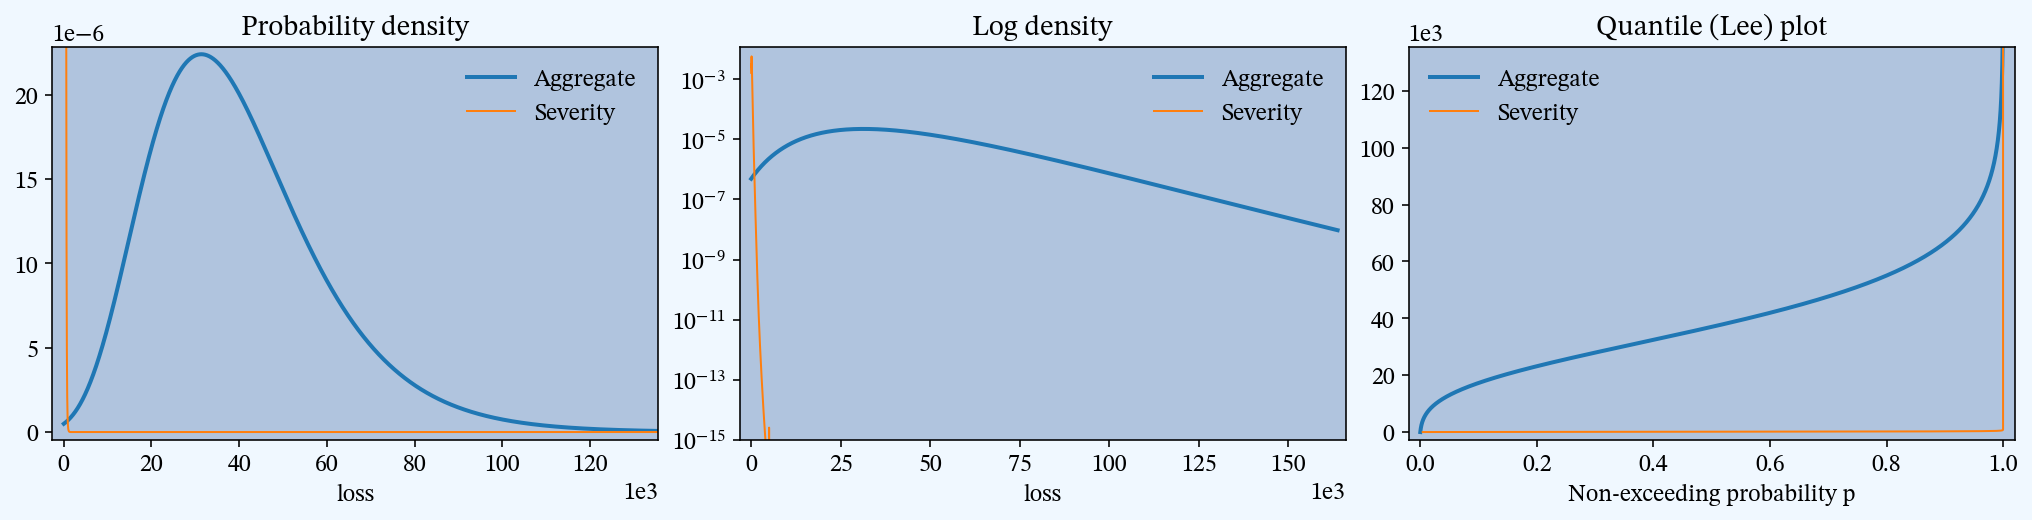

time: 1.24 s (started: 2022-10-25 21:48:21 +01:00)


In [18]:
eg5.plot()

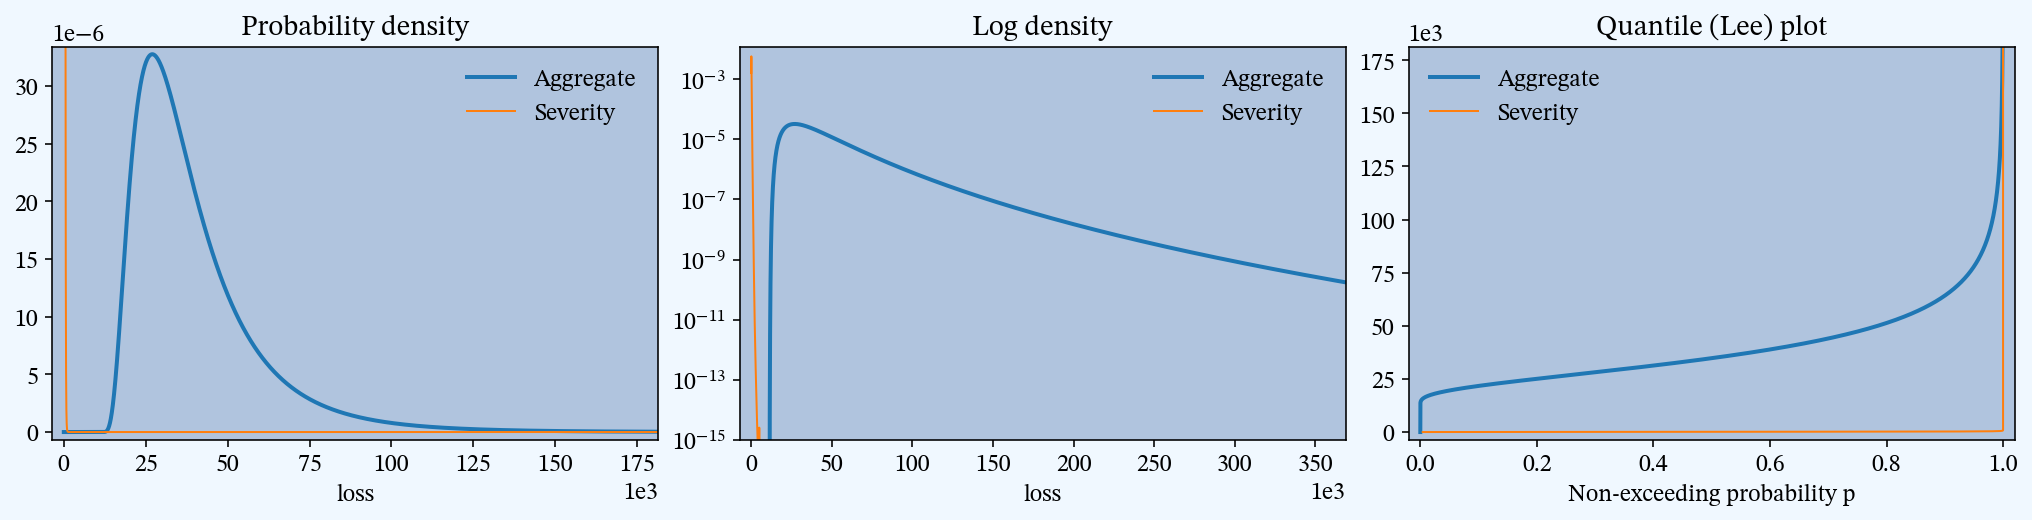

time: 2.66 s (started: 2022-10-25 21:48:22 +01:00)


In [19]:
eg5d.plot()

Created: 2022-07-06 from `Aggregate` class docstring. (REALLY? HOW?)